In [257]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
from scipy import misc
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam



In [258]:
def load_data(directory):
    images = []
    labels = []

    for label in ['yes', 'no']:
        path = os.path.join(directory, label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                images.append(image)
                labels.append(label)
    
    return images, labels

directory = r"/Users/patry/Desktop/Brain Tumor detection/archive"
images, labels = load_data(directory)


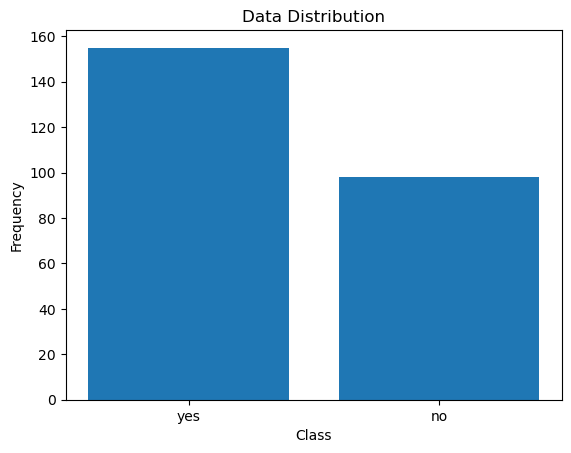

In [259]:
def plot_data_distribution(labels):
    # Count the number of occurrences of each class
    counts = Counter(labels)

    # Create a bar plot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Data Distribution')
    plt.show()

plot_data_distribution(labels)


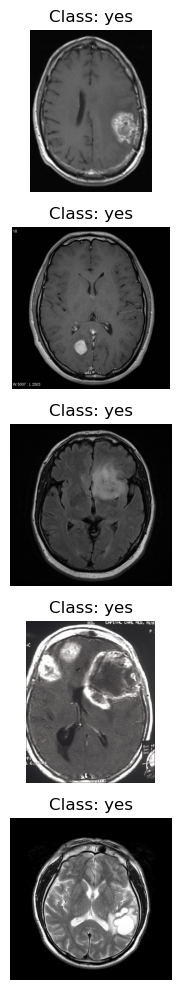

In [260]:
def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(12, 2 * num_samples))

    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


plot_sample_images(images, labels)

In [276]:
def crop_brain_contour(image, plot=False):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding to create a binary image
    thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest external contour in the image is the skull
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y+h, x:x+w]
    else:
        cropped_image = image  # If no contour is found, return the original image

    if plot:
        # Plot the images for comparison
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title('Thresholded Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image')
        plt.axis('off')
        plt.show()

    return cropped_image


In [277]:
image_size = (240,240)
def load_and_preprocess_images(directory):
    images = []
    labels = []

    for label in ['yes', 'no']:  # Folder names as labels
        folder_path = os.path.join(directory, label)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                cropped_image = crop_brain_contour(image)
                cropped_image = cv2.resize(cropped_image, dsize = image_size, interpolation=cv2.INTER_CUBIC)
                cropped_image = cropped_image 
                images.append(cropped_image)
                labels.append(label)  # Storing the label

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images(directory)


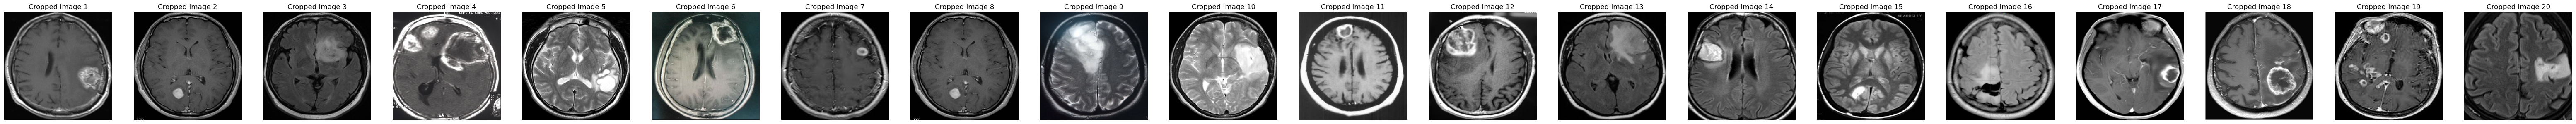

In [278]:
def show_cropped_images(images, num_images=20):
    plt.figure(figsize=(80, 80))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(f'Cropped Image {i+1}')
        plt.axis('off')
    plt.show()

show_cropped_images(images)


In [279]:
def augment_images(images, labels):
    data_gen = ImageDataGenerator(
        rotation_range=8,
        width_shift_range=0.01,
        height_shift_range=0.01,
        shear_range=0.1,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.5, 1.3),
        fill_mode='nearest'
    )

    augmented_images = []
    augmented_labels = []

    for img, label in zip(images, labels):
        img = img.reshape((1,) + img.shape)

        # Setting augmentation to 6 for images with tumor and to 9 for images without tumor
        augmentation_factor = 5 if label == "yes" else 7

        i = 0
        for batch in data_gen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(label)
            i += 1
            if i >= augmentation_factor:
                break

    return np.array(augmented_images), np.array(augmented_labels)

augmented_images, augmented_labels = augment_images(images, labels)


In [280]:
print(len(augmented_labels))

1461


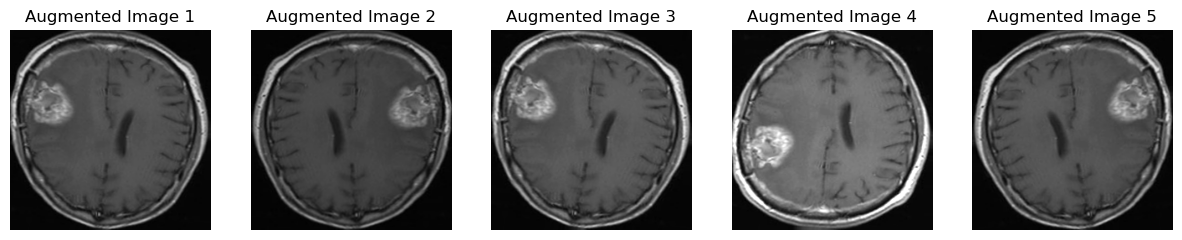

In [281]:
def show_augmented_images(images, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(f'Augmented Image {i+1}')
        plt.axis('off')
    plt.show()

show_augmented_images(augmented_images)


In [282]:
len(augmented_images)

1461

In [283]:
def split_data(images, labels, test_size=0.2, val_size=0.2):
    # Convert labels to numerical format
    labels = np.array([1 if label == 'yes' else 0 for label in labels])

    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

    # Split training set into training and validation sets
    val_size_rel = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_rel, random_state=42)

    return np.array(X_train), np.array(X_val), np.array(X_test), y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = split_data(augmented_images, augmented_labels)

In [284]:
len(X_train)

876

In [285]:
def build_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = build_model()


Epoch 1/10
28/28 [==============================] - 67s 2s/step - loss: 61.1058 - accuracy: 0.5525 - val_loss: 0.6608 - val_accuracy: 0.5034
Epoch 2/10
28/28 [==============================] - 60s 2s/step - loss: 0.6381 - accuracy: 0.6347 - val_loss: 0.6407 - val_accuracy: 0.6199
Epoch 3/10
28/28 [==============================] - 59s 2s/step - loss: 0.5023 - accuracy: 0.7511 - val_loss: 0.5906 - val_accuracy: 0.7568
Epoch 4/10
28/28 [==============================] - 83s 3s/step - loss: 0.3886 - accuracy: 0.8196 - val_loss: 0.6239 - val_accuracy: 0.7500
Epoch 5/10
28/28 [==============================] - 76s 3s/step - loss: 0.2855 - accuracy: 0.8858 - val_loss: 0.4297 - val_accuracy: 0.8425
Epoch 6/10
28/28 [==============================] - 67s 2s/step - loss: 0.1510 - accuracy: 0.9395 - val_loss: 0.4747 - val_accuracy: 0.8253
Epoch 7/10
28/28 [==============================] - 71s 3s/step - loss: 0.1871 - accuracy: 0.9338 - val_loss: 0.5864 - val_accuracy: 0.8219
Epoch 8/10
28/28 [=

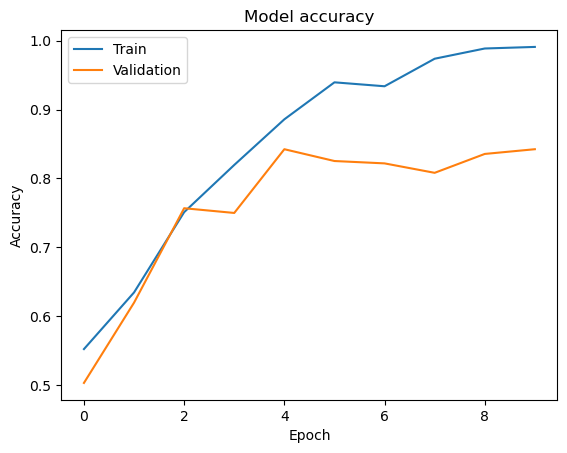

In [286]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    return history

history = train_model(model, X_train, y_train, X_val, y_val)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

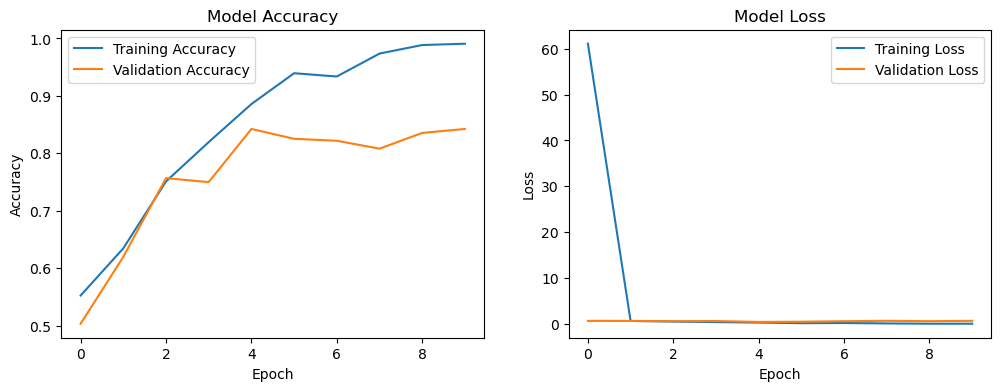

In [287]:
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


10/10 [==============================] - 5s 508ms/step


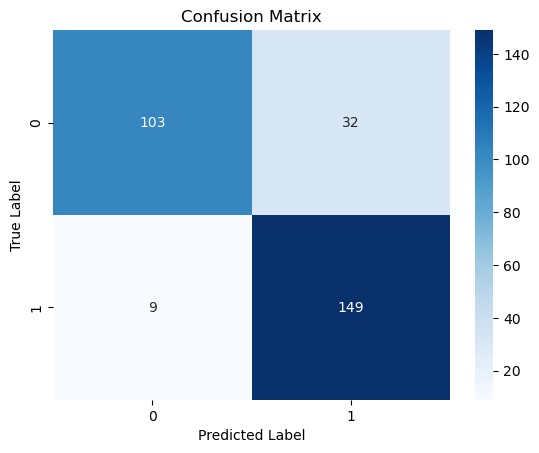

In [288]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

    cm = confusion_matrix(y_test, y_pred_classes)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(model, X_test, y_test)


In [289]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with SciKeras KerasClassifier
model = KerasClassifier(model=create_model, epochs=10, batch_size=32)

# Define the grid search parameters
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1]
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, std_score in zip(grid_result.cv_results_['params'], 
                                         grid_result.cv_results_['mean_test_score'], 
                                         grid_result.cv_results_['std_test_score']):
    print("%f (%f) with: %r" % (mean_score, std_score, params))


Epoch 1/10
19/19 [==============================] - 24s 1s/step - loss: 1380.9491 - accuracy: 0.5205
Epoch 2/10
19/19 [==============================] - 18s 941ms/step - loss: 285.4226 - accuracy: 0.5753
Epoch 3/10
19/19 [==============================] - 18s 929ms/step - loss: 189.2378 - accuracy: 0.6866
Epoch 4/10
19/19 [==============================] - 18s 975ms/step - loss: 32.7693 - accuracy: 0.8408
Epoch 5/10
19/19 [==============================] - 20s 1s/step - loss: 10.0246 - accuracy: 0.8990
Epoch 6/10
19/19 [==============================] - 18s 937ms/step - loss: 4.1670 - accuracy: 0.9349
Epoch 7/10
19/19 [==============================] - 19s 962ms/step - loss: 1.3199 - accuracy: 0.9726
Epoch 8/10
19/19 [==============================] - 21s 1s/step - loss: 0.0275 - accuracy: 0.9966
Epoch 9/10
19/19 [==============================] - 21s 1s/step - loss: 0.0109 - accuracy: 0.9983
Epoch 10/10
10/10 [==============================] - 3s 260ms/step
Epoch 1/10
19/19 [=========

19/19 [==============================] - 24s 1s/step - loss: 0.7022 - accuracy: 0.4949
Epoch 10/10
10/10 [==============================] - 2s 236ms/step
Epoch 1/10
19/19 [==============================] - 33s 936ms/step - loss: 370658.6250 - accuracy: 0.5137
Epoch 2/10
19/19 [==============================] - 17s 906ms/step - loss: 0.7071 - accuracy: 0.4914
Epoch 3/10
19/19 [==============================] - 17s 909ms/step - loss: 0.6988 - accuracy: 0.5120
Epoch 4/10
19/19 [==============================] - 19s 1s/step - loss: 0.6929 - accuracy: 0.4812
Epoch 5/10
19/19 [==============================] - 25s 1s/step - loss: 0.6956 - accuracy: 0.5154
Epoch 6/10
19/19 [==============================] - 28s 1s/step - loss: 0.6916 - accuracy: 0.5291
Epoch 7/10
19/19 [==============================] - 25s 1s/step - loss: 0.7000 - accuracy: 0.4846
Epoch 8/10
19/19 [==============================] - 26s 1s/step - loss: 0.6948 - accuracy: 0.5257
Epoch 9/10
19/19 [==============================

Epoch 1/20
28/28 [==============================] - 66s 2s/step - loss: 99.2439 - accuracy: 0.4966 - val_loss: 0.6695 - val_accuracy: 0.6267
Epoch 2/20
28/28 [==============================] - 63s 2s/step - loss: 0.6589 - accuracy: 0.6290 - val_loss: 0.6051 - val_accuracy: 0.6712
Epoch 3/20
28/28 [==============================] - 63s 2s/step - loss: 0.5931 - accuracy: 0.6998 - val_loss: 0.5144 - val_accuracy: 0.7192
Epoch 4/20
28/28 [==============================] - 63s 2s/step - loss: 0.5392 - accuracy: 0.7500 - val_loss: 0.4953 - val_accuracy: 0.7671
Epoch 5/20
28/28 [==============================] - 68s 2s/step - loss: 0.5034 - accuracy: 0.7432 - val_loss: 0.5367 - val_accuracy: 0.7466
Epoch 6/20
28/28 [==============================] - 80s 3s/step - loss: 0.4155 - accuracy: 0.8139 - val_loss: 0.4811 - val_accuracy: 0.7877
Epoch 7/20
28/28 [==============================] - 76s 3s/step - loss: 0.3377 - accuracy: 0.8699 - val_loss: 0.4433 - val_accuracy: 0.8048
Epoch 8/20
28/28 [=

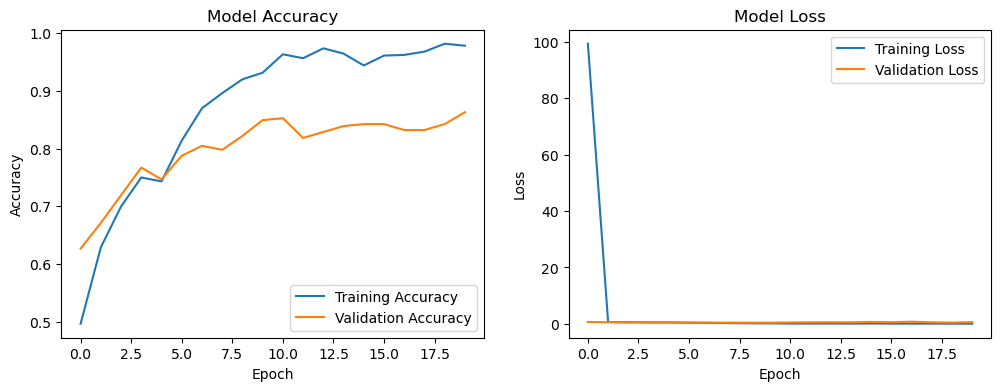

In [290]:
def create_optimized_model(input_shape=(240, 240, 3), learning_rate=0.001):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model with the optimal learning rate
model = create_optimized_model()

# Train the model (assuming you have already prepared your training and validation data)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
plot_training_history(history)

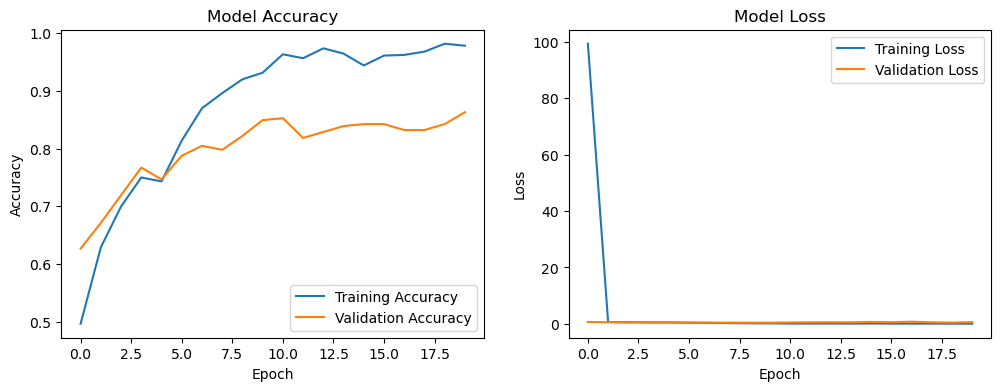

In [291]:
plot_training_history(history)

10/10 [==============================] - 5s 511ms/step


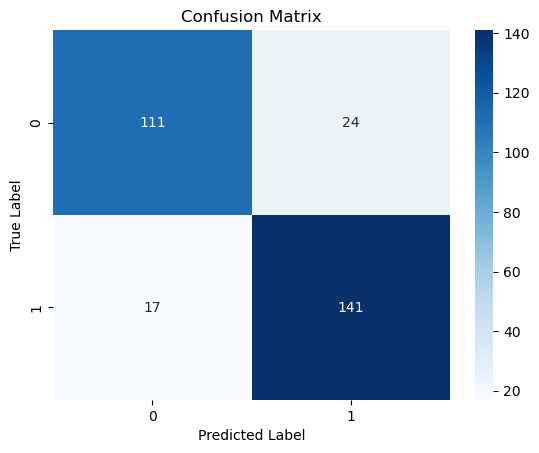

In [292]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Epoch 1/10
28/28 [==============================] - 413s 15s/step - loss: 2.2159 - accuracy: 0.7580 - val_loss: 0.3762 - val_accuracy: 0.9144
Epoch 2/10
28/28 [==============================] - 390s 14s/step - loss: 0.3533 - accuracy: 0.9087 - val_loss: 0.1854 - val_accuracy: 0.9452
Epoch 3/10
28/28 [==============================] - 388s 14s/step - loss: 0.1743 - accuracy: 0.9509 - val_loss: 0.1172 - val_accuracy: 0.9452
Epoch 4/10
28/28 [==============================] - 404s 15s/step - loss: 0.0897 - accuracy: 0.9715 - val_loss: 0.0876 - val_accuracy: 0.9692
Epoch 5/10
28/28 [==============================] - 386s 14s/step - loss: 0.0842 - accuracy: 0.9680 - val_loss: 0.0845 - val_accuracy: 0.9726
Epoch 6/10
28/28 [==============================] - 391s 14s/step - loss: 0.0388 - accuracy: 0.9863 - val_loss: 0.0598 - val_accuracy: 0.9760
Epoch 7/10
28/28 [==============================] - 386s 14s/step - loss: 0.0276 - accuracy: 0.9920 - val_loss: 0.0570 - val_accuracy: 0.9795
Epoch 

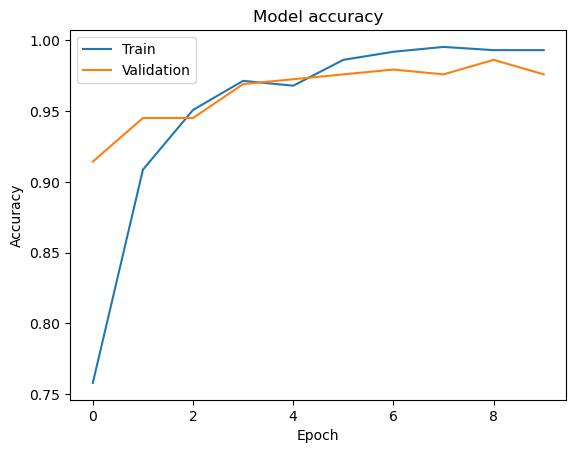

In [293]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

def build_vgg16_transfer_model(input_shape=(240, 240, 3)):
    # Load VGG16 pre-trained on ImageNet data
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 (not training them)
    for layer in vgg16.layers:
        layer.trainable = False

    # Create a new input layer (matching your image size)
    input_tensor = Input(shape=input_shape)

    # Use the VGG16 model as a "layer"
    base_model = vgg16(input_tensor)

    # Add custom layers on top of VGG16
    x = Flatten()(base_model)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)  # Assuming binary classification

    # Create a new model
    model = Model(inputs=input_tensor, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
vgg16_model = build_vgg16_transfer_model()

# Train the model (assuming you have your data in X_train, y_train, X_val, y_val)
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
# Plot training & validation accuracy values
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

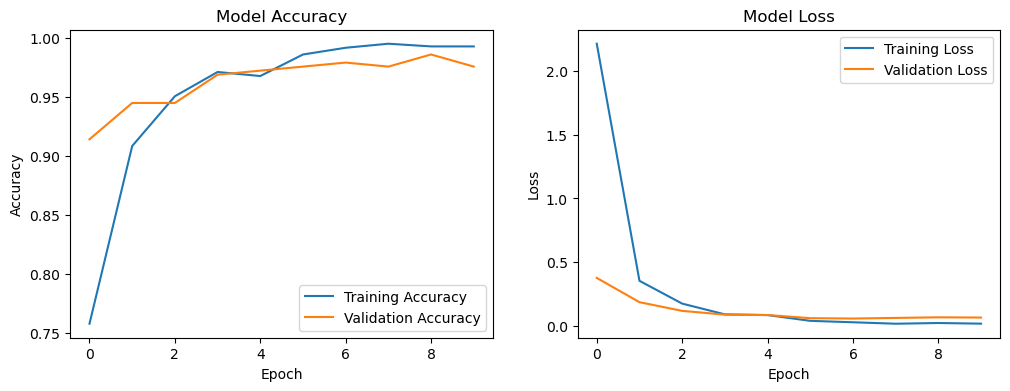

In [294]:
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(vgg16_history)

In [295]:
# Unfreeze the top layers of VGG16
vgg16_model.get_layer('vgg16').trainable = True
for layer in vgg16_model.get_layer('vgg16').layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False

# Recompile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
continued_history = vgg16_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/5
28/28 [==============================] - 486s 17s/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0680 - val_accuracy: 0.9795
Epoch 2/5
28/28 [==============================] - 474s 17s/step - loss: 0.0137 - accuracy: 0.9966 - val_loss: 0.0647 - val_accuracy: 0.9863
Epoch 3/5
28/28 [==============================] - 432s 16s/step - loss: 0.0310 - accuracy: 0.9909 - val_loss: 0.0866 - val_accuracy: 0.9760
Epoch 4/5
28/28 [==============================] - 428s 15s/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.0742 - val_accuracy: 0.9863
Epoch 5/5
28/28 [==============================] - 424s 15s/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0768 - val_accuracy: 0.9863


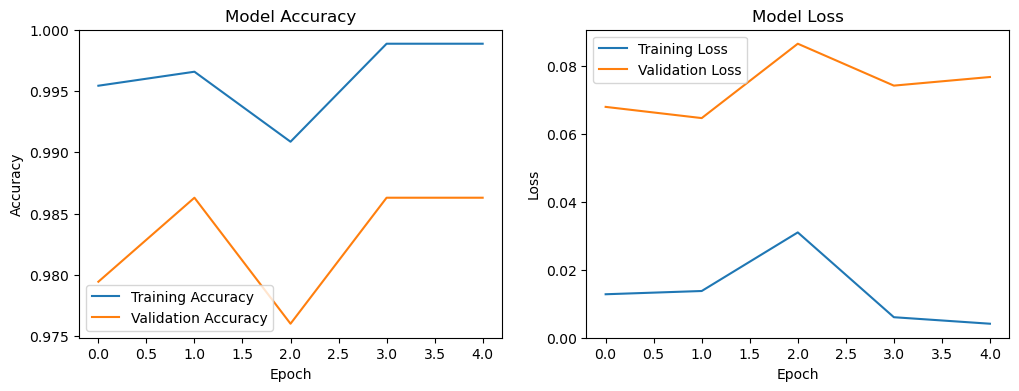

In [296]:
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(continued_history)